In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline
from imblearn.base import BaseSampler

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
X = pd.read_csv("X_data.csv")
y = pd.read_csv("y_data.csv").Status

In [3]:
numeric_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
                   'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
categorical_unordered_features = ["Drug", "Sex"]
categorical_ordered_features = ["Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

Code explaination in EvaluationNonSMOTENC

In [4]:
class CustomKNNImputer(KNNImputer):
    def __init__(self, n_neighbors=5, weights="uniform", **kwargs):
        super().__init__(n_neighbors=n_neighbors, weights=weights, **kwargs)
        self.n_neighbors = n_neighbors
        self.weights = weights
        global y
        self.y = y.copy()
    
    def fit(self, X, y=None):
        self.imputer_by_class_ = {}
        for cls in self.y.unique():
            indices = self.y[self.y.index.isin(X.index) & (self.y == cls)].index
            self.imputer_by_class_[cls] = KNNImputer(n_neighbors=self.n_neighbors, weights=self.weights).fit(X.loc[indices])
        return self
    
    def transform(self, X):
        for cls, imputer in self.imputer_by_class_.items():
            indices = self.y[self.y.index.isin(X.index) & (self.y == cls)].index
            X.loc[indices] = imputer.transform(X.loc[indices])
        return X

class CustomSimpleImputer(SimpleImputer):
    def __init__(self, strategy="most_frequent", **kwargs):
        super().__init__(strategy=strategy, **kwargs)
        self.strategy = strategy
        global y
        self.y = y.copy()
        
    def fit(self, X, y=None):
        self.imputer_by_class_ = {}
        for cls in self.y.unique():
            indices = self.y[self.y.index.isin(X.index) & (self.y == cls)].index
            self.imputer_by_class_[cls] = SimpleImputer(strategy=self.strategy).fit(X.loc[indices])
        return self
    
    def transform(self, X):
        for cls, imputer in self.imputer_by_class_.items():
            indices = self.y[self.y.index.isin(X.index) & (self.y == cls)].index
            X.loc[indices] = imputer.transform(X.loc[indices])
        return X

In [5]:
class CustomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, custom_orders):
        self.custom_orders = custom_orders
        self.ordinal_encoders = {}
        self.one_hot_encoders = {}

    def fit(self, X, y=None):
        X.columns = X.columns.astype(str) #per risolvere alcuni errori
        categorical_cols = X.select_dtypes(include=['category']).columns.tolist()

        for col in categorical_cols:
            if col in ['11', '12']: #Sex and Drug columns
                one_hot_encoder = OneHotEncoder()
                one_hot_encoder.fit(X[[col]].values.reshape(-1, 1))
                self.one_hot_encoders[col] = one_hot_encoder
            elif col in ['13', '14', '15', '16', '17']:
                categories = self.custom_orders[int(col)]
                #each category is specified like the custom ordinal encoder in EvaluationKB
                encoder = OrdinalEncoder(categories=[categories], handle_unknown='use_encoded_value', unknown_value=-1)
                encoder.fit(X[[col]])
                self.ordinal_encoders[col] = encoder
        return self

    def transform(self, X):
        X.columns = X.columns.astype(str) #per risolvere alcuni errori
        
        for col, encoder in self.ordinal_encoders.items():
            transformed_values = encoder.transform(X[[col]]).flatten()
            X[col] = transformed_values
        
        for col, encoder in self.one_hot_encoders.items():
            transformed_values = encoder.transform(X[[col]]).toarray()
            column_names = [f'{col}_{i}' for i in range(transformed_values.shape[1])]
            encoded_df = pd.DataFrame(transformed_values, columns=column_names, index=X.index)
            X = pd.concat([X, encoded_df], axis=1).drop(columns=[col])
        
        return X

custom_orders = {
    13: ['N', 'Y'],
    14: ['N', 'Y'],
    15: ['N', 'Y'],
    16: ['N', 'S', 'Y'],
    17: ['1.0', '2.0', '3.0', '4.0']
}

In [6]:
class SmoteNCBalancer(BaseSampler):
    def __init__(self, k_neighbors=5):
        self.k_neighbors = k_neighbors

    def _fit_resample(self, X, y):
        return self.fit_resample(X, y)
        
    def fit_resample(self, X, y):
        categorical_columns = X.select_dtypes(include=['category']).columns
        #print(categorical_columns)
        categorical_indices = [X.columns.get_loc(col) for col in categorical_columns]
        self.class_counts = Counter(y)
        #print(Counter(y))
        
        sampling_strategy = {
            "Low chance": self.class_counts["Low chance"],
            "Transplant needed": self.class_counts["Low chance"]
        }
        
        smotenc = SMOTENC(
            random_state=0,
            k_neighbors=self.k_neighbors,
            categorical_features=categorical_indices,
            sampling_strategy=sampling_strategy
        )
        X_resampled, y_resampled = smotenc.fit_resample(X, y)
        #print(Counter(y_resampled))
        
        return X_resampled, y_resampled

class ENNBalancer(BaseSampler):
    def __init__(self, k_neighbors_cleaning=5):
        self.k_neighbors_cleaning = k_neighbors_cleaning

    def _fit_resample(self, X, y):
        return self.fit_resample(X, y)
        
    def fit_resample(self, X, y):
        self.class_counts = Counter(y)
        #print(self.class_counts)
        
        enn = EditedNearestNeighbours(
            sampling_strategy=["High chance"],
            n_neighbors=self.k_neighbors_cleaning
        )
        X_resampled, y_resampled = enn.fit_resample(X, y)
        #print(Counter(y_resampled))
        
        return X_resampled, y_resampled

In [7]:
class MixedKBestMutualInfoSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k_num=5, k_cat=7, random_state=None):
        self.k_num = k_num
        self.k_cat = k_cat
        self.random_state = random_state
        
    def fit(self, X, y):
        X = pd.DataFrame(X)
        
        for col in X.columns[:11]:
            X[col] = X[col].astype('float64')
        for col in X.columns[11:]:
            X[col] = X[col].astype('category')

        self.numerical_features = X.select_dtypes(include=['float64']).columns
        self.categorical_features = X.select_dtypes(include=['category']).columns
        
        mi_numerical = [(feature, mutual_info_classif(X.loc[:, [feature]], y, random_state=self.random_state)) \
                                                    for feature in self.numerical_features]
        #print(mi_numerical)
        
        #categorical features
        mi_categorical = [(feature, self._mutual_info(X[feature], y)) for feature in self.categorical_features]
        #print(mi_categorical)

        self.sorted_num_features = [feature for feature, _ in sorted(mi_numerical, key=lambda x: x[1], reverse=True)]
        self.sorted_cat_features = [feature for feature, _ in sorted(mi_categorical, key=lambda x: x[1], reverse=True)]
        #print(str(self.sorted_num_features) + "----------" + str(self.sorted_cat_features))
        
        return self
    
    def _mutual_info(self, X, y):
        X = X.astype(str)
        
        joint_probs = np.zeros((len(np.unique(X)), len(np.unique(y))))
        for i, xi in enumerate(np.unique(X)):
            for j, yj in enumerate(np.unique(y)):
                joint_probs[i, j] = np.sum((X == xi) & (y == yj)) / len(X)
        
        px = np.sum(joint_probs, axis=1)
        py = np.sum(joint_probs, axis=0)
        
        mi = 0
        for i, xi in enumerate(np.unique(X)):
            for j, yj in enumerate(np.unique(y)):
                if joint_probs[i, j] != 0:
                    mi += joint_probs[i, j] * np.log2(joint_probs[i, j] / (px[i] * py[j]))
        
        return mi
    
    def transform(self, X):
        X = pd.DataFrame(X)
        
        for col in X.columns[:11]:
            X[col] = X[col].astype('float64')
        for col in X.columns[11:]:
            X[col] = X[col].astype('category')
        #print("num: " + str(self.k_num), ", cat:" + str(self.k_cat))
        selected_features = np.concatenate([self.sorted_cat_features[:self.k_cat], self.sorted_num_features[:self.k_num]])
        #print(str(selected_features))
        
        return X[selected_features]

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", CustomKNNImputer()),
            ("scaler", RobustScaler())
        ]), numeric_features),
        ("cat_unord", Pipeline([
            ("imputer", CustomSimpleImputer(strategy="most_frequent")),
        ]), categorical_unordered_features),
        ("cat_ord", Pipeline([
            ("imputer", CustomSimpleImputer(strategy="most_frequent")),
        ]), categorical_ordered_features)
    ]
)

In [9]:
clf_RandomForest = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("feature_selector", MixedKBestMutualInfoSelector(random_state=0)),
        ('sampler1', SmoteNCBalancer()),
        ('encoder', CustomEncoder(custom_orders)),
        ('sampler2', ENNBalancer()),
        ("classifier", RandomForestClassifier(random_state=0, n_jobs=-1))
    ]
)
clf_KNNeighbor = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("feature_selector", MixedKBestMutualInfoSelector(random_state=0)),
        ('sampler1', SmoteNCBalancer()),
        ('encoder', CustomEncoder(custom_orders)),
        ('sampler2', ENNBalancer()),
        ("classifier", KNeighborsClassifier(n_jobs=-1))
    ]
)
clf_AdaBoostGNB = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("feature_selector", MixedKBestMutualInfoSelector(random_state=0)),
        ('sampler1', SmoteNCBalancer()),
        ('encoder', CustomEncoder(custom_orders)),
        ('sampler2', ENNBalancer()),
        ("classifier", AdaBoostClassifier(random_state=0, estimator=GaussianNB(), algorithm="SAMME"))
    ]
)
clf_LogReg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("feature_selector", MixedKBestMutualInfoSelector(random_state=0)),
        ('sampler1', SmoteNCBalancer()),
        ('encoder', CustomEncoder(custom_orders)),
        ('sampler2', ENNBalancer()),
        ("classifier", LogisticRegression(random_state=0))
    ]
)

clf_RandomForest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomKNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['N_Days', 'Age', 'Bilirubin',
                                                   'Cholesterol', 'Albumin',
                                                   'Copper', 'Alk_Phos', 'SGOT',
                                                   'Tryglicerides', 'Platelets',
                                                   'Prothrombin']),
                                                 ('cat_unord',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomSimpleImputer())]),
                                                  ['Drug', 'Sex']),...
                                                  ['Ascites', 'Hepatomegaly',
                                                   'Spiders', 'Edema',
                                                   'Stage'])])),
                ('feature_selector',
                 MixedKBestMutualInfoSelector(random_state=0)),
                ('sampler1', SmoteNCBalancer()),
                ('encoder',
                 CustomEncoder(custom_orders={13: ['N', 'Y'], 14: ['N', 'Y'],
                                              15: ['N', 'Y'],
                                              16: ['N', 'S', 'Y'],
                                              17: ['1.0', '2.0', '3.0',
                                                   '4.0']})),
                ('sampler2', ENNBalancer()),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=0))])

In [10]:
param_grid_RandomForest = {
    "preprocessor__num__imputer__n_neighbors": range(3, 16),

    "feature_selector__k_num": range(1, 12),
    "feature_selector__k_cat": range(1, 8),

    "sampler1__k_neighbors": range(2, 9, 2),
    "sampler2__k_neighbors_cleaning": range(3, 10, 2),
    
    "classifier__max_depth": range(2, 8),
    "classifier__criterion": ["gini", "entropy"],
}

param_grid_KNNeighbor = {
    "preprocessor__num__imputer__n_neighbors": range(3, 16),

    "feature_selector__k_num": range(1, 12),
    "feature_selector__k_cat": range(1, 8),
    
    "sampler1__k_neighbors": range(2, 9, 2),
    "sampler2__k_neighbors_cleaning": range(3, 10, 2),
    
    "classifier__n_neighbors": range(3, 18, 2),
}

param_grid_AdaBoostGNB = {
    "preprocessor__num__imputer__n_neighbors": range(3, 16),

    "feature_selector__k_num": range(1, 12),
    "feature_selector__k_cat": range(1, 8),
    
    "sampler1__k_neighbors": range(2, 9, 2),
    "sampler2__k_neighbors_cleaning": range(3, 10, 2),
    
    "classifier__learning_rate": [0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5],
}

param_grid_LogReg = {
    "preprocessor__num__imputer__n_neighbors": range(3, 16),

    "feature_selector__k_num": range(1, 12),
    "feature_selector__k_cat": range(1, 8),
    
    "sampler1__k_neighbors": range(2, 9, 2),
    "sampler2__k_neighbors_cleaning": range(3, 10, 2),
    
    "classifier__C": [0.01, 0.1, 1, 10, 100],
}

In [11]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scorer = "f1_macro"

Print procedure explained in EvaluationNonSMOTENC

Random Forest best parameters: {'sampler2__k_neighbors_cleaning': 3, 'sampler1__k_neighbors': 8, 'preprocessor__num__imputer__n_neighbors': 15, 'feature_selector__k_num': 11, 'feature_selector__k_cat': 2, 'classifier__max_depth': 5, 'classifier__criterion': 'gini'}
                   precision    recall  f1-score   support

      High chance       0.94      0.65      0.77        23
       Low chance       0.82      0.82      0.82        17
Transplant needed       0.22      1.00      0.36         2

         accuracy                           0.74        42
        macro avg       0.66      0.83      0.65        42
     weighted avg       0.86      0.74      0.77        42

                   precision    recall  f1-score   support

      High chance       0.91      0.88      0.89        24
       Low chance       0.94      0.94      0.94        16
Transplant needed       0.33      0.50      0.40         2

         accuracy                           0.88        42
        macro avg    

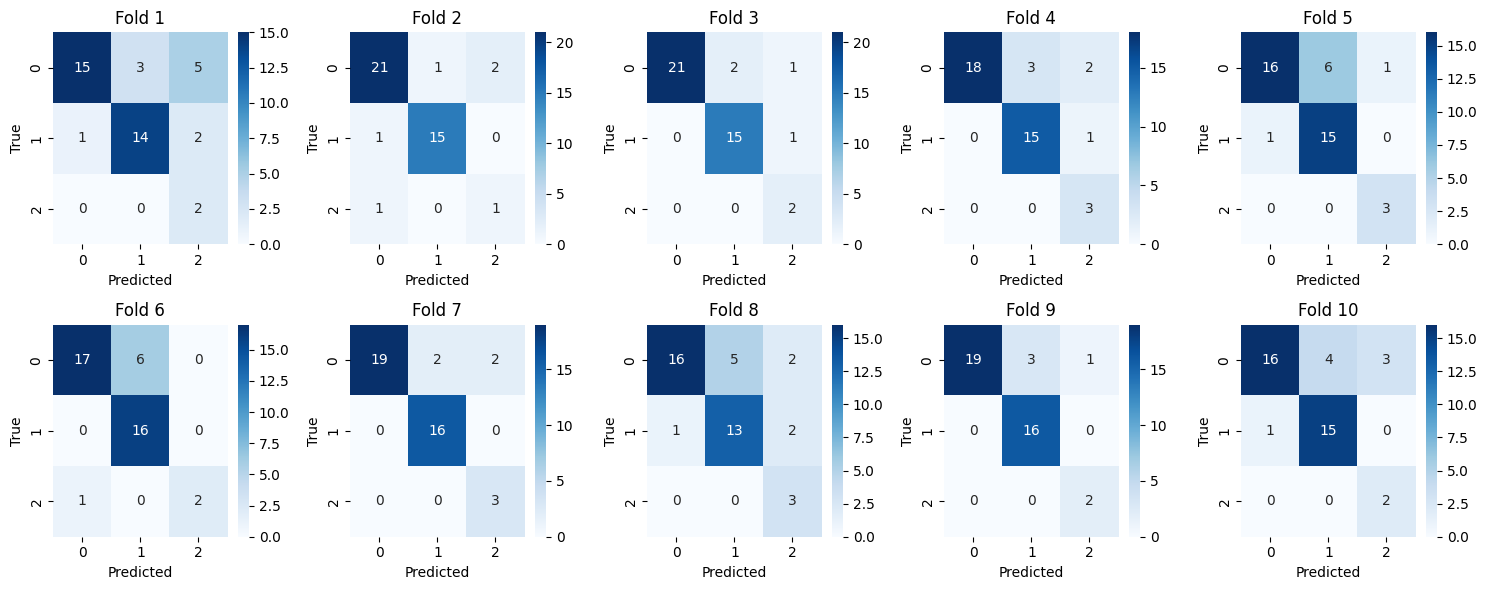

In [12]:
clfrf = RandomizedSearchCV(
    estimator = clf_RandomForest, 
    param_distributions=param_grid_RandomForest,
    cv = skf,
    scoring = scorer,
    n_jobs=-1,
    random_state=0,
    n_iter=20,
)
clfrf.fit(X, y)

best_params = clfrf.best_params_
print("Random Forest best parameters:", best_params)

f_macro_scores1 = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_fold_train, X_fold_valid = X.iloc[train_index], X.iloc[test_index]
    y_fold_train, y_fold_valid = y.iloc[train_index], y.iloc[test_index]

    y_pred = clfrf.predict(X_fold_valid)

    cm = confusion_matrix(y_fold_valid, y_pred)
    report = classification_report(y_fold_valid, y_pred, output_dict=False)
    print(report)
    report = classification_report(y_fold_valid, y_pred, output_dict=True)
    f_macro_scores1.append(report["macro avg"]["f1-score"])

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[fold // 5, fold % 5])
    axes[fold // 5, fold % 5].set_title(f'Fold {fold+1}')
    axes[fold // 5, fold % 5].set_xlabel('Predicted')
    axes[fold // 5, fold % 5].set_ylabel('True')

plt.tight_layout()
plt.show()

KNN best parameters: {'sampler2__k_neighbors_cleaning': 3, 'sampler1__k_neighbors': 8, 'preprocessor__num__imputer__n_neighbors': 15, 'feature_selector__k_num': 11, 'feature_selector__k_cat': 2, 'classifier__n_neighbors': 9}
                   precision    recall  f1-score   support

      High chance       0.80      0.52      0.63        23
       Low chance       0.89      0.47      0.62        17
Transplant needed       0.11      1.00      0.20         2

         accuracy                           0.52        42
        macro avg       0.60      0.66      0.48        42
     weighted avg       0.80      0.52      0.60        42

                   precision    recall  f1-score   support

      High chance       0.87      0.83      0.85        24
       Low chance       0.80      0.50      0.62        16
Transplant needed       0.22      1.00      0.36         2

         accuracy                           0.71        42
        macro avg       0.63      0.78      0.61        42
   

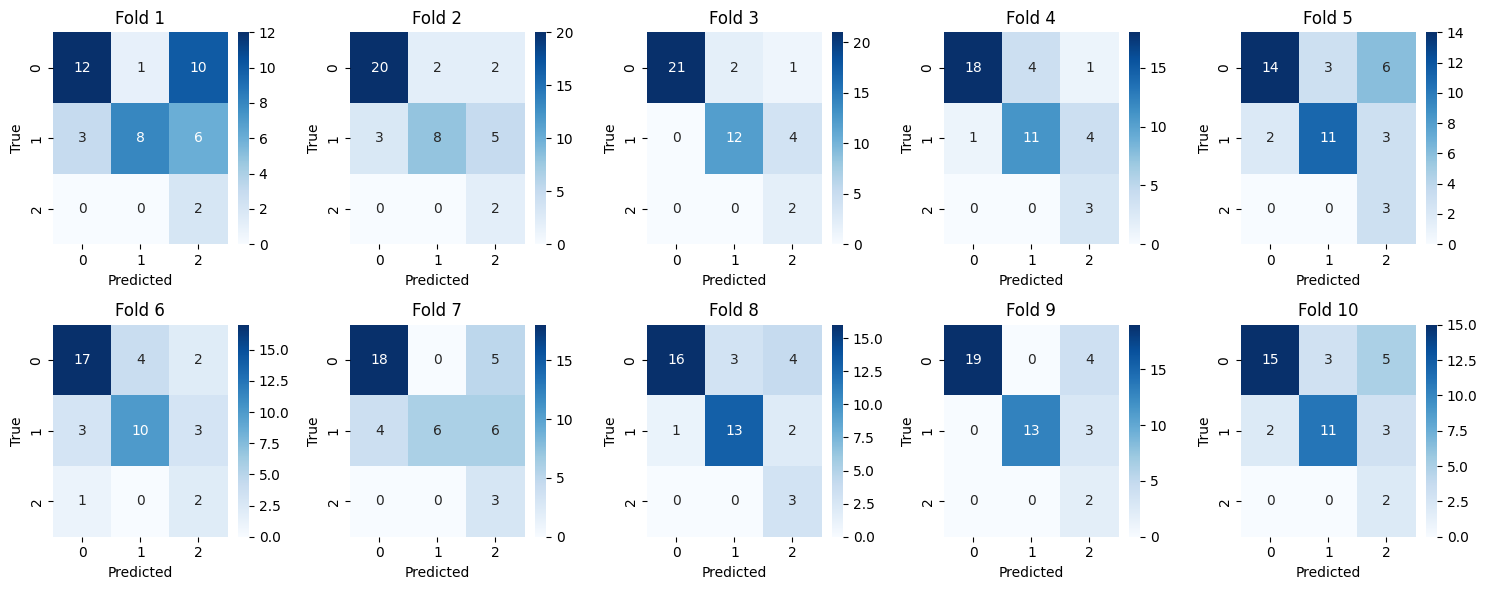

In [13]:
clfknn = RandomizedSearchCV(
    estimator = clf_KNNeighbor, 
    param_distributions=param_grid_KNNeighbor,
    cv = skf,
    scoring = scorer,
    n_jobs=-1,
    random_state=0,
    n_iter=20,
)
clfknn.fit(X, y)

best_params = clfknn.best_params_
print("KNN best parameters:", best_params)

f_macro_scores2 = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_fold_train, X_fold_valid = X.iloc[train_index], X.iloc[test_index]
    y_fold_train, y_fold_valid = y.iloc[train_index], y.iloc[test_index]

    y_pred = clfknn.predict(X_fold_valid)

    cm = confusion_matrix(y_fold_valid, y_pred)
    report = classification_report(y_fold_valid, y_pred, output_dict=False)
    print(report)
    report = classification_report(y_fold_valid, y_pred, output_dict=True)
    f_macro_scores2.append(report["macro avg"]["f1-score"])

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[fold // 5, fold % 5])
    axes[fold // 5, fold % 5].set_title(f'Fold {fold+1}')
    axes[fold // 5, fold % 5].set_xlabel('Predicted')
    axes[fold // 5, fold % 5].set_ylabel('True')

plt.tight_layout()
plt.show()

C:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
6 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python312\Lib\site-packages\imblearn\pipeline.py", line 326, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "C:\P

ADABoost best parameters: {'sampler2__k_neighbors_cleaning': 3, 'sampler1__k_neighbors': 8, 'preprocessor__num__imputer__n_neighbors': 5, 'feature_selector__k_num': 10, 'feature_selector__k_cat': 2, 'classifier__learning_rate': 1.2}
                   precision    recall  f1-score   support

      High chance       0.92      0.52      0.67        23
       Low chance       0.59      0.59      0.59        17
Transplant needed       0.17      1.00      0.29         2

         accuracy                           0.57        42
        macro avg       0.56      0.70      0.51        42
     weighted avg       0.75      0.57      0.62        42

                   precision    recall  f1-score   support

      High chance       0.81      0.71      0.76        24
       Low chance       0.73      0.69      0.71        16
Transplant needed       0.17      0.50      0.25         2

         accuracy                           0.69        42
        macro avg       0.57      0.63      0.57      

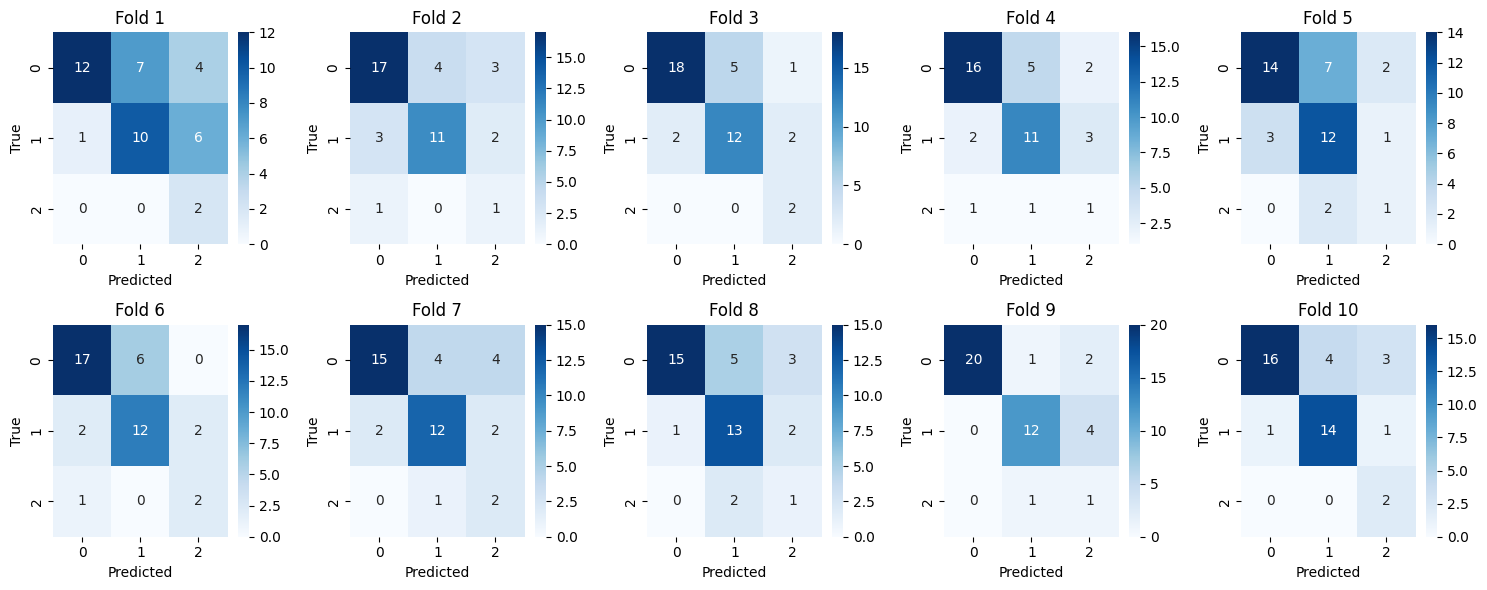

In [14]:
clfadagnb = RandomizedSearchCV(
    estimator = clf_AdaBoostGNB, 
    param_distributions=param_grid_AdaBoostGNB,
    cv = skf,
    scoring = scorer,
    n_jobs=-1,
    random_state=0,
    n_iter=20,
)
clfadagnb.fit(X, y)

best_params = clfadagnb.best_params_
print("ADABoost best parameters:", best_params)

f_macro_scores3 = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_fold_train, X_fold_valid = X.iloc[train_index], X.iloc[test_index]
    y_fold_train, y_fold_valid = y.iloc[train_index], y.iloc[test_index]

    y_pred = clfadagnb.predict(X_fold_valid)

    cm = confusion_matrix(y_fold_valid, y_pred)
    report = classification_report(y_fold_valid, y_pred, output_dict=False)
    print(report)
    report = classification_report(y_fold_valid, y_pred, output_dict=True)
    f_macro_scores3.append(report["macro avg"]["f1-score"])

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[fold // 5, fold % 5])
    axes[fold // 5, fold % 5].set_title(f'Fold {fold+1}')
    axes[fold // 5, fold % 5].set_xlabel('Predicted')
    axes[fold // 5, fold % 5].set_ylabel('True')

plt.tight_layout()
plt.show()

Logistic Regression best parameters: {'sampler2__k_neighbors_cleaning': 3, 'sampler1__k_neighbors': 8, 'preprocessor__num__imputer__n_neighbors': 15, 'feature_selector__k_num': 11, 'feature_selector__k_cat': 2, 'classifier__C': 10}
                   precision    recall  f1-score   support

      High chance       0.86      0.52      0.65        23
       Low chance       0.69      0.65      0.67        17
Transplant needed       0.17      1.00      0.29         2

         accuracy                           0.60        42
        macro avg       0.57      0.72      0.53        42
     weighted avg       0.76      0.60      0.64        42

                   precision    recall  f1-score   support

      High chance       0.87      0.83      0.85        24
       Low chance       0.78      0.88      0.82        16
Transplant needed       1.00      0.50      0.67         2

         accuracy                           0.83        42
        macro avg       0.88      0.74      0.78       

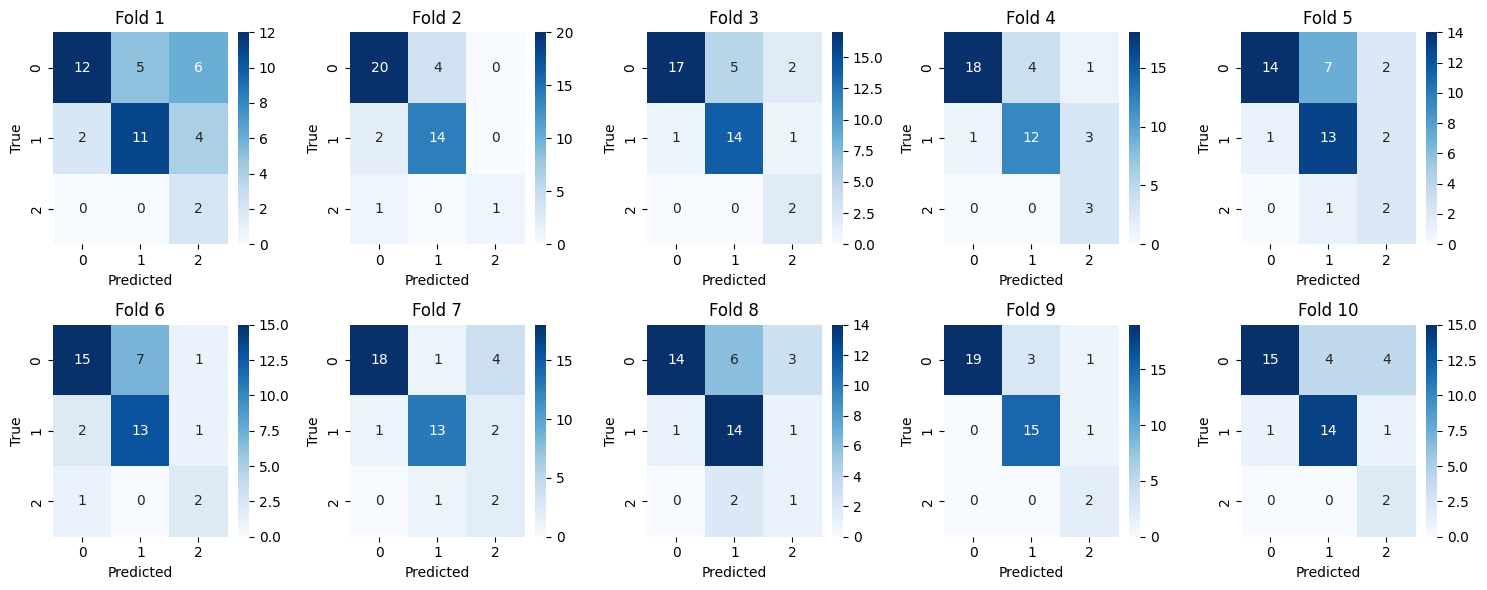

In [15]:
clflr = RandomizedSearchCV(
    estimator = clf_LogReg, 
    param_distributions=param_grid_LogReg,
    cv = skf,
    scoring = scorer,
    n_jobs=-1,
    random_state=0,
    n_iter=20,
)
clflr.fit(X, y)

best_params = clflr.best_params_
print("Logistic Regression best parameters:", best_params)

f_macro_scores4 = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_fold_train, X_fold_valid = X.iloc[train_index], X.iloc[test_index]
    y_fold_train, y_fold_valid = y.iloc[train_index], y.iloc[test_index]

    y_pred = clflr.predict(X_fold_valid)

    cm = confusion_matrix(y_fold_valid, y_pred)
    report = classification_report(y_fold_valid, y_pred, output_dict=False)
    print(report)
    report = classification_report(y_fold_valid, y_pred, output_dict=True)
    f_macro_scores4.append(report["macro avg"]["f1-score"])

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[fold // 5, fold % 5])
    axes[fold // 5, fold % 5].set_title(f'Fold {fold+1}')
    axes[fold // 5, fold % 5].set_xlabel('Predicted')
    axes[fold // 5, fold % 5].set_ylabel('True')

plt.tight_layout()
plt.show()

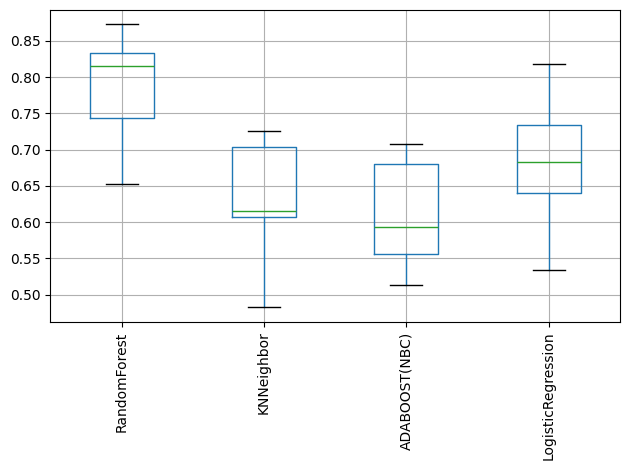

In [16]:
cv_scores = {
    'RandomForest': f_macro_scores1,
    'KNNeighbor': f_macro_scores2,
    'ADABOOST(NBC)': f_macro_scores3,
    'LogisticRegression': f_macro_scores4
}

df_cv_scores = pd.DataFrame(cv_scores)

df_cv_scores.boxplot()
plt.xticks(ticks=range(1, len(df_cv_scores.columns) + 1), labels=df_cv_scores.columns, rotation=90)
plt.tight_layout()
#plt.savefig("stat_result SMOTENC.png")
plt.show()

C:\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


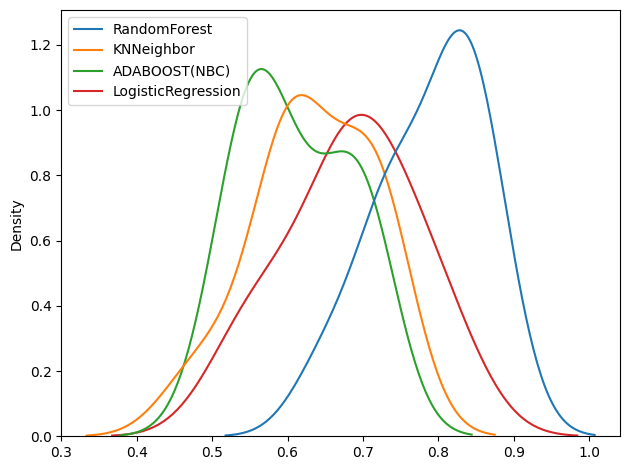

In [17]:
import scipy.stats as stats

sns.kdeplot(data=df_cv_scores)
plt.tight_layout()
#plt.savefig("SMOTENC KDE plot.png")
plt.show()

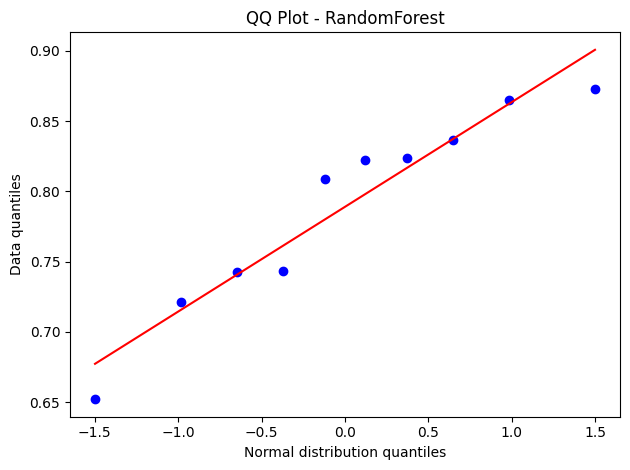

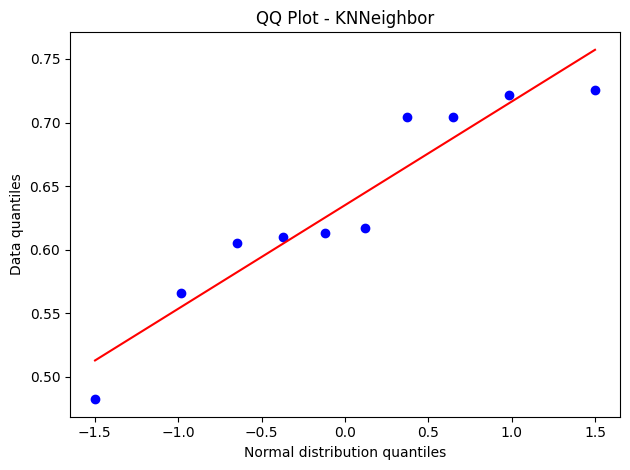

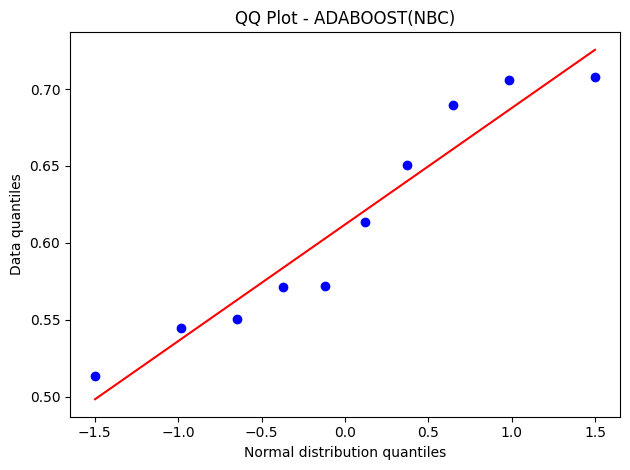

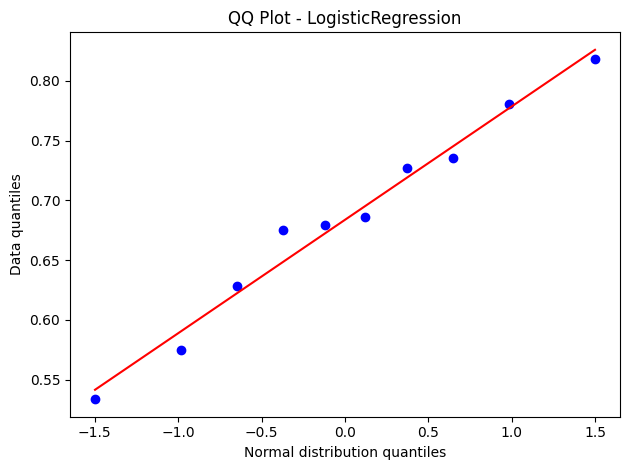

In [18]:
for i, col in enumerate(df_cv_scores.columns):
    stats.probplot(df_cv_scores[col], plot=plt)
    plt.title(f'QQ Plot - {col}')
    plt.xlabel('Normal distribution quantiles')
    plt.ylabel('Data quantiles')
    plt.tight_layout()
    #plt.savefig(f"SMOTENC_Test_QQ_Plot_{col}.png")

    plt.show()

In [19]:
statistic, p_value = stats.levene(cv_scores["RandomForest"], 
                                 cv_scores["KNNeighbor"], 
                                 cv_scores["ADABOOST(NBC)"], 
                                 cv_scores["LogisticRegression"])

print("Levene's statistic:", statistic)
print("p value:", p_value)

if p_value < 0.05:
    print("There is evidence to reject the null hypothesis of equal variances.")
else:
    print("There is no evidence to reject the null hypothesis of equal variances.")

Levene's statistic: 0.0809357948703925
p value: 0.9699625551028712
There is no evidence to reject the null hypothesis of equal variances.


In [20]:
from scipy.stats import kruskal
from itertools import combinations
from scipy.stats import wilcoxon

kruskal_result = kruskal(cv_scores["RandomForest"], 
                         cv_scores["KNNeighbor"], 
                         cv_scores["ADABOOST(NBC)"], 
                         cv_scores["LogisticRegression"])

print("Kruskal-Wallis statistic:", kruskal_result.statistic)
print("p value:", kruskal_result.pvalue)

if kruskal_result.pvalue < 0.05:
    print("There is a statistically relevant difference between at least two groups.")
    models = ["RandomForest", "KNNeighbor", "ADABOOST(NBC)", "LogisticRegression"]
    couples = list(combinations(models, 2))
    
    for _ in couples:
        m1, m2 = _
        wilcoxon_result = wilcoxon(cv_scores[m1], cv_scores[m2])
        
        print("Comparing", m1, "and", m2)
        print("Wilcoxon statistic:", wilcoxon_result.statistic)
        print("p value:", wilcoxon_result.pvalue)
        
        if wilcoxon_result.pvalue < 0.05:
            print("There is a statistically relevant difference between", m1, "and", m2)
        else:
            print("There is no statistically relevant difference between", m1, "and", m2)
        print("----")
else:
    print("There are no statistically relevant difference between groups.")

Kruskal-Wallis statistic: 18.045365853658552
p value: 0.0004304744375195307
There is a statistically relevant difference between at least two groups.
Comparing RandomForest and KNNeighbor
Wilcoxon statistic: 0.0
p value: 0.001953125
There is a statistically relevant difference between RandomForest and KNNeighbor
----
Comparing RandomForest and ADABOOST(NBC)
Wilcoxon statistic: 0.0
p value: 0.001953125
There is a statistically relevant difference between RandomForest and ADABOOST(NBC)
----
Comparing RandomForest and LogisticRegression
Wilcoxon statistic: 1.0
p value: 0.00390625
There is a statistically relevant difference between RandomForest and LogisticRegression
----
Comparing KNNeighbor and ADABOOST(NBC)
Wilcoxon statistic: 21.0
p value: 0.556640625
There is no statistically relevant difference between KNNeighbor and ADABOOST(NBC)
----
Comparing KNNeighbor and LogisticRegression
Wilcoxon statistic: 9.0
p value: 0.064453125
There is no statistically relevant difference between KNNeig

In [21]:
#np.save("RandomForestSMOTENC.npy", cv_scores["RandomForest"])